# Traffic Data Viewer
A Jupyter Notebook for visualizing WSDOT traffic data

Note: The data is stored assuming UTC timezone, however most of these functions take the parameter `local_tz`, allowing you to convert to the timezone of your choice. The default value of `local_tz` is US/Pacific.

In [204]:
%matplotlib notebook

In [2]:
import sys
sys.path.append('../')

In [101]:
import pandas
from scipy import stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import traffic.dbutil as dbutil

In [20]:
name_table = dbutil.get_nameidtable()

In [5]:
d = dbutil.get_travel_times([96])

In [21]:
route_name = d['Description'].any()
print(route_name)

Downtown Seattle to Downtown Bellevue via I-90


In [7]:
def weekdayName(i):
    return ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"][i]

# Filtering

Filter to weekdays only, in the hours 3pm-7pm, to look at the PM rush hour commute.

Then we take the mean of the samples in that hour band (eg: the travel times at 4:15, 4:35, 4:55 are averaged and stored in the 4pm row for a particular date). We do this because we want to look at the entire hour as a unit and we know that the 3 samples taken during a single hour are not independent. In other words: bad traffic at 4:15pm probably implies bad traffic at 4:35pm as well. Taking the average gives us a single point for each hour.

In [214]:
d1 = d.weekdays()
d1 = d1.hours_filter(15, 18)
d1['Hour'] = d1.apply(lambda row: row['TimeUpdated'].hour, axis=1)
d1['Weekday'] = d1.apply(lambda row: weekdayName(row['TimeUpdated'].weekday()), axis=1)
d1['Date'] = d1.apply(lambda row: row['TimeUpdated'].date(), axis=1)
tidy = d1[['Date', 'Weekday','Hour', 'CurrentTime']]
tidy = tidy.rename(columns={'CurrentTime': 'TravelTimeMinutes'})

In [215]:
tidy_mean = tidy.groupby(['Date', 'Weekday', 'Hour']).mean().reset_index()

# Plotting


### Boxplot
The boxplot allows us to easily compare between hours in a weekday and between weekdays. Whiskers represent the 1st and 99th percentiles.

In [216]:
sns.boxplot(x="Weekday", y="TravelTimeMinutes", hue="Hour", data=tidy_mean, whis=[1, 99]).set_title(route_name)

Text(0.5,1,'Downtown Seattle to Downtown Bellevue via I-90')

<IPython.core.display.Javascript object>


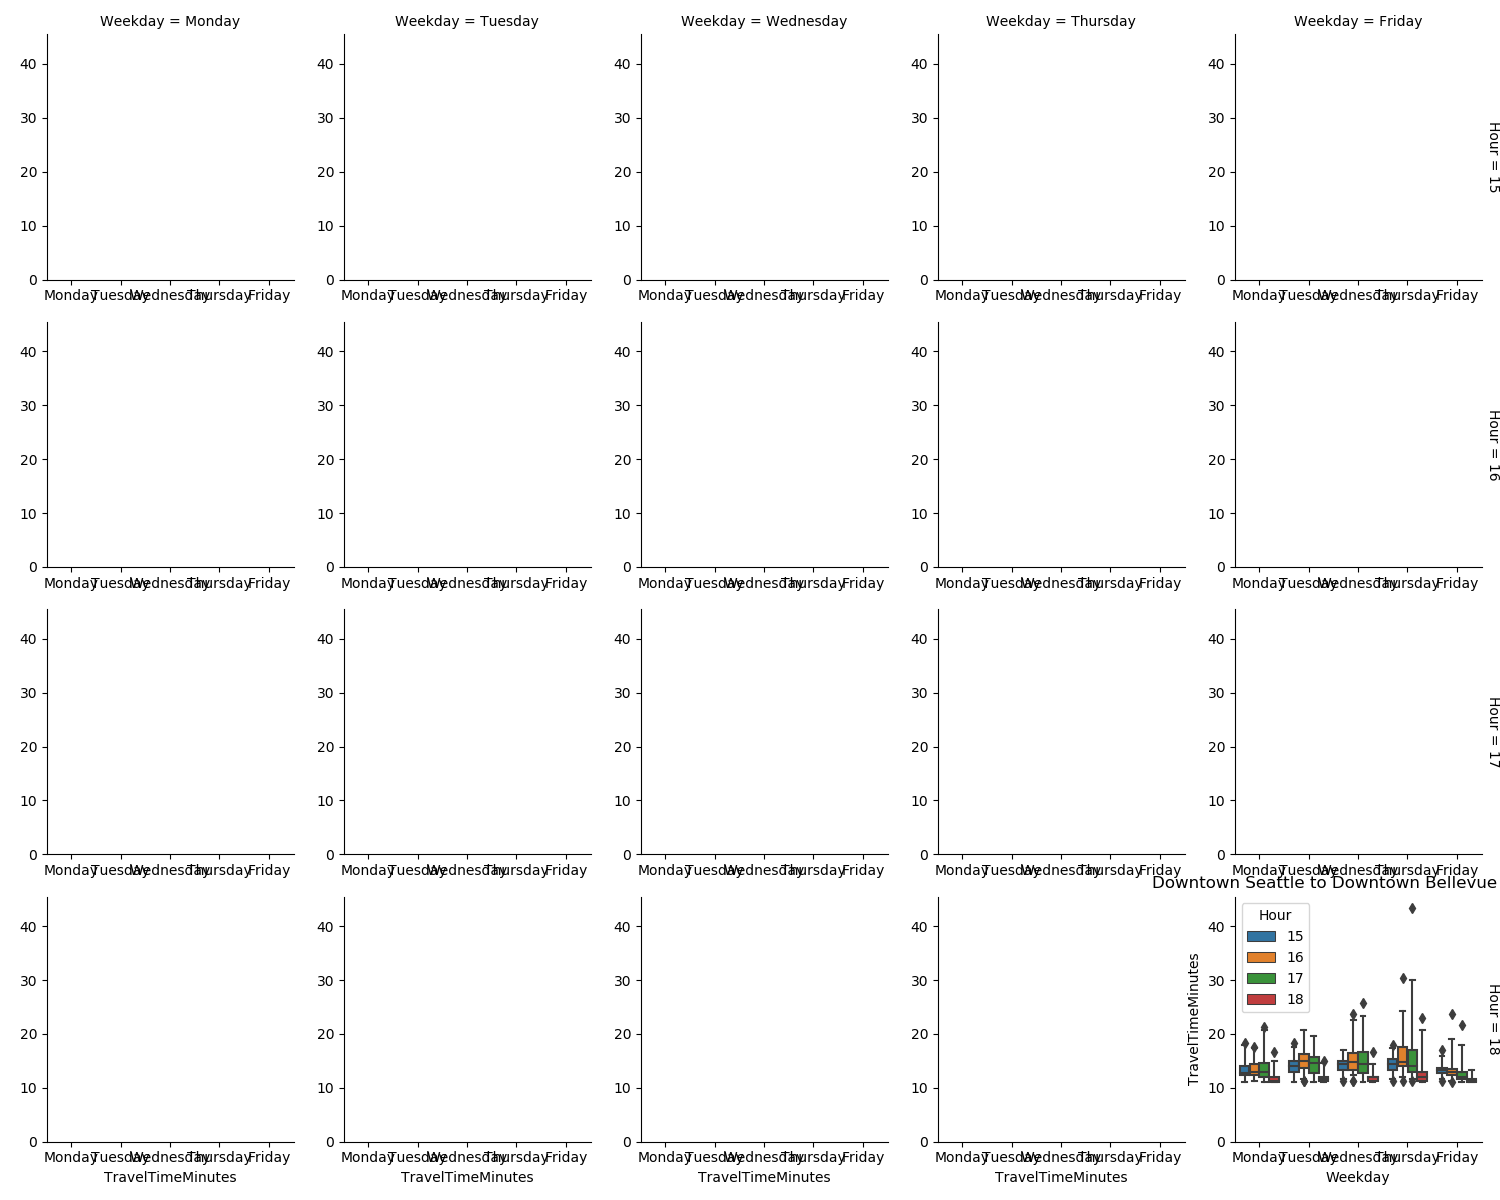

In [217]:
g = sns.FacetGrid(tidy_mean, col="Weekday", row="Hour", margin_titles=True)
g.map(plt.hist, "TravelTimeMinutes", normed=True, cumulative=True)

<IPython.core.display.Javascript object>


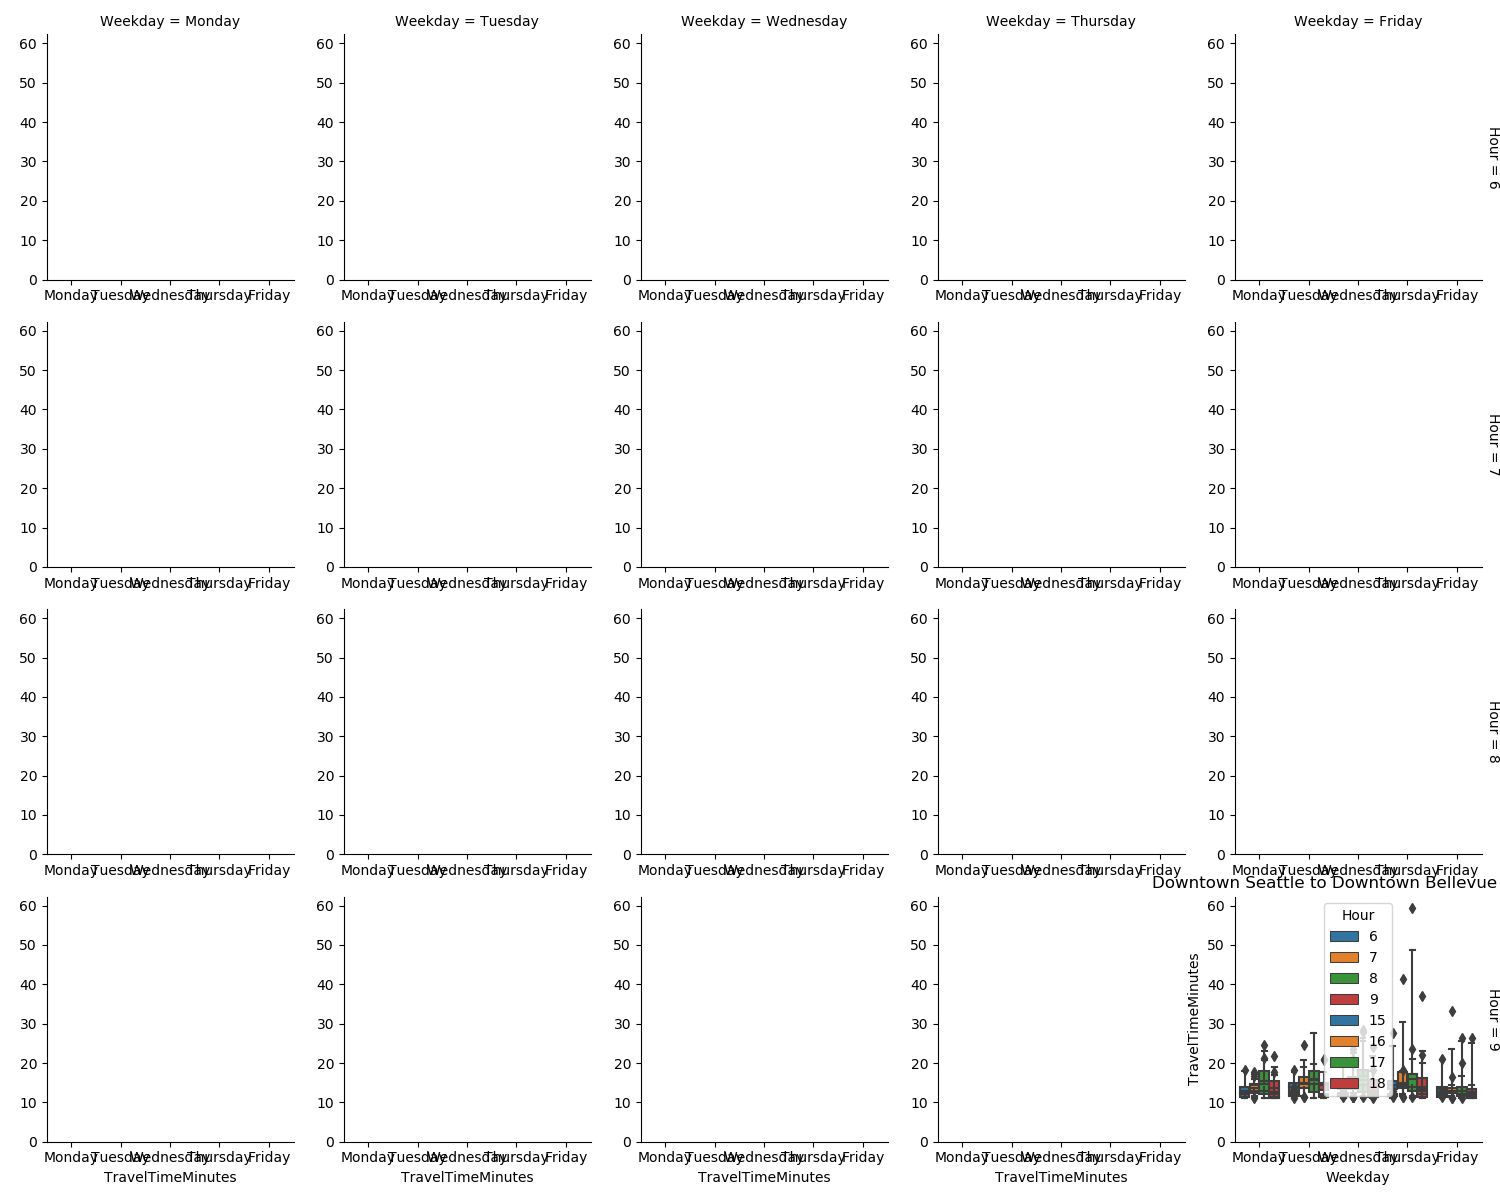

In [207]:
g2 = sns.FacetGrid(tidy_mean, col="Weekday", row="Hour", margin_titles=True)
g2.map(plt.hist, "TravelTimeMinutes", normed=True)

# Next Steps

1. Filter outliers > 2.5 stdevs
2. Exclude Christmas/Thanksgiving weeks
3. Boxplot of filtered data

In [218]:
# GroupBy - Calculate Mean
m = tidy_mean.groupby(['Weekday', 'Hour']).mean().rename(columns={'TravelTimeMinutes': 'MeanTime'}).reset_index()

In [219]:
# Join tidy_mean with GroupBy Mean
merged = pandas.merge(tidy_mean, m)

In [220]:
# GroupBy - Calculate Std
m2 = merged.groupby(['Weekday', 'Hour']).std().rename(columns={'TravelTimeMinutes': 'Std'}).reset_index()
m2 = m2[['Weekday','Hour', 'Std']]

In [221]:
merged2 = pandas.merge(merged, m2)
zscored = merged2

In [222]:
# Keep that data which is fewer than 3 standard deviations from the mean
zscored['ZScore'] = merged2.apply(lambda row: (row['TravelTimeMinutes'] - row['MeanTime'])/row['Std'], axis=1)
no_outliers = zscored[np.abs(zscored['ZScore']) < 3]

In [223]:
sns.boxplot(x="Weekday", y="TravelTimeMinutes", hue="Hour", data=no_outliers, whis=[1, 99]).set_title(route_name)

Text(0.5,1,'Downtown Seattle to Downtown Bellevue via I-90')